In [1]:
#Python Default 

#Essentials

import numpy as np

#from objproxies import *

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

#Qiskit
    
## Qiskit Nature
    
from qiskit_nature.units import *   #ANGSTROM

from qiskit_nature.second_q.drivers import *    #PySCFDriver

from qiskit_nature.second_q.mappers import * #JordanWignerMapper

from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.problems import ElectronicStructureProblem

from qiskit_nature.second_q.circuit.library import *  #Ansatz, HF

## Qiskit Algorithms
    
from qiskit_algorithms.minimum_eigensolvers import *    #VQE
 
from qiskit_algorithms.optimizers import *    #SLSQP

## Qiskit Primitives

from qiskit.primitives import Estimator as Estimator_Nature

from qiskit_aer.primitives.estimator import Estimator as Estimator_Aer

## Qiskit Noise Models

from qiskit_aer.noise import NoiseModel

from qiskit.providers.fake_provider import *

##Qiskit Runtime IBM

from qiskit_ibm_runtime import QiskitRuntimeService

%matplotlib widget


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


# Definindo Funções

In [2]:
class Error_Qiskit:
    
    pass

class GroundState_H2:
    
    class Driver :
        
        def __init__(self, a, base, driver, charge, spin, unit):
            
            self._drivers = driver(
                atom= f"H 0 0 0; H 0 0 {a}",
                basis=base,
                charge=charge,
                spin=spin,
                unit=unit,
            )

        def run_driver(self) -> ElectronicStructureProblem:
            
            return self._drivers.run()
    
    def __init__(self, base = 'sto3g', unit = DistanceUnit.ANGSTROM, driver = PySCFDriver, charge = 0, spin = 0):
        
        self._problem = None
        self._dist = None
        self._base = base
        self._unit = unit
        self._driver = driver
        self._charge = charge
        self._spin = spin
        self._mapper = None
    
    def mapper(self):
        
        return self._mapper
    
    def problem (self, a = None) -> ElectronicStructureProblem:
        
        dist = self._dist if self._dist != None else a
        
        return self.Driver(dist, self._base, self._driver, self._charge, self._spin, self._unit).run_driver()
        
    def groundstate(self, a, mapper = JordanWignerMapper(), solver = NumPyMinimumEigensolver) -> float:
        
        self._mapper = mapper
        self._dist = a
        self._problem = self.problem(a)

        return (result := GroundStateEigensolver(mapper, solver()).solve(self._problem)).groundenergy + result.nuclear_repulsion_energy
    
    def groundstate_curve(self, a, mapper = JordanWignerMapper(), solver = NumPyMinimumEigensolver) -> iter:
        
        for dist in a:

            yield self.groundstate(dist, mapper, solver)
    
class Solver(GroundState_H2):
    
    def __init__(self, GroundState, estimator = Estimator_Nature, ansatz = UCCSD, optimizer = SLSQP):
        
        self._problem = GroundState._problem
        self._mapper = GroundState._mapper
        self._estimator, self.estimator = estimator(), estimator
        self._optimizer, self.optimizer = optimizer(), optimizer
        self._ansatz, self.ansatz = ansatz(), ansatz
    
    def Ansatz(self):
    
        self._ansatz = self.ansatz(
            self._problem.num_spatial_orbitals,
            self._problem.num_particles,
            self._mapper, 
            initial_state=HartreeFock(
            self._problem.num_spatial_orbitals,
            self._problem.num_particles,
            self._mapper)
            )
        
        return self
        
    def Estimator(self, shots = None, seed = 1, noise = None, session = None):
        
        if self.estimator == Estimator_Nature:
            
            self._estimator = self.estimator(options = {'shots': shots, 'seed': None})
        
        else:
            
            if shots == None:
                
                self._estimator = self.estimator(run_options = {"shots": None}, approximation=True)
        
            elif noise != None:
            
                self._estimator = self.estimator(backend_options = {"coupling_map": noise().coupling_map, "noise_model": NoiseModel.from_backend(noise())}, run_options = {"shots": shots, 'seed': seed}, transpile_options = {"seed_transpiler": seed})
            
            else:
                
                self._estimator = self.estimator(run_options = {"shots": shots, 'seed': seed}, transpile_options = {"seed_transpiler": seed})
                        
        print(shots)
        
        return self
    
        
    def teste_Estimator(self, shots = None, seed = 1, noise = None, session = None):
        
        estimators = {'Estimator_Nature' : 'options', 'Estimator_Aer' : 'run_options'}
        
        options = f'{estimators[self.estimator]} = {{"shots": {shots}, "seed": {seed}}}'

        
        self._estimator = self.estimator(options)
        
        return self
    
    def Vqe(self):
    
        return VQE(self._estimator, self._ansatz, self._optimizer)
    

# Comparando Diferentes Tipos de Fitting

In [3]:
intervalo_total = np.concatenate(((intervalo := np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))), (intervalo_distante := np.linspace(20, 30, 10))))

def polyfit(x, intervalo):
    
    return (y := list(GroundState_H2().groundstate_curve(intervalo))), np.polyfit(intervalo, y, x)

for a in (metodos := range(2, 13)):
    
    exec(f"energy_polyfit_{a}, coef_polyfit_{a} = polyfit(a, intervalo)")
    exec(f"coef_polyfit_inportante_{a} = np.polyfit(intervalo_importante, (energy_polyfit_importante_{a} := energy_polyfit_{a}[:len(intervalo_importante)]), a)")

Text(0.5, 0.98, 'GroundState Energy H2')

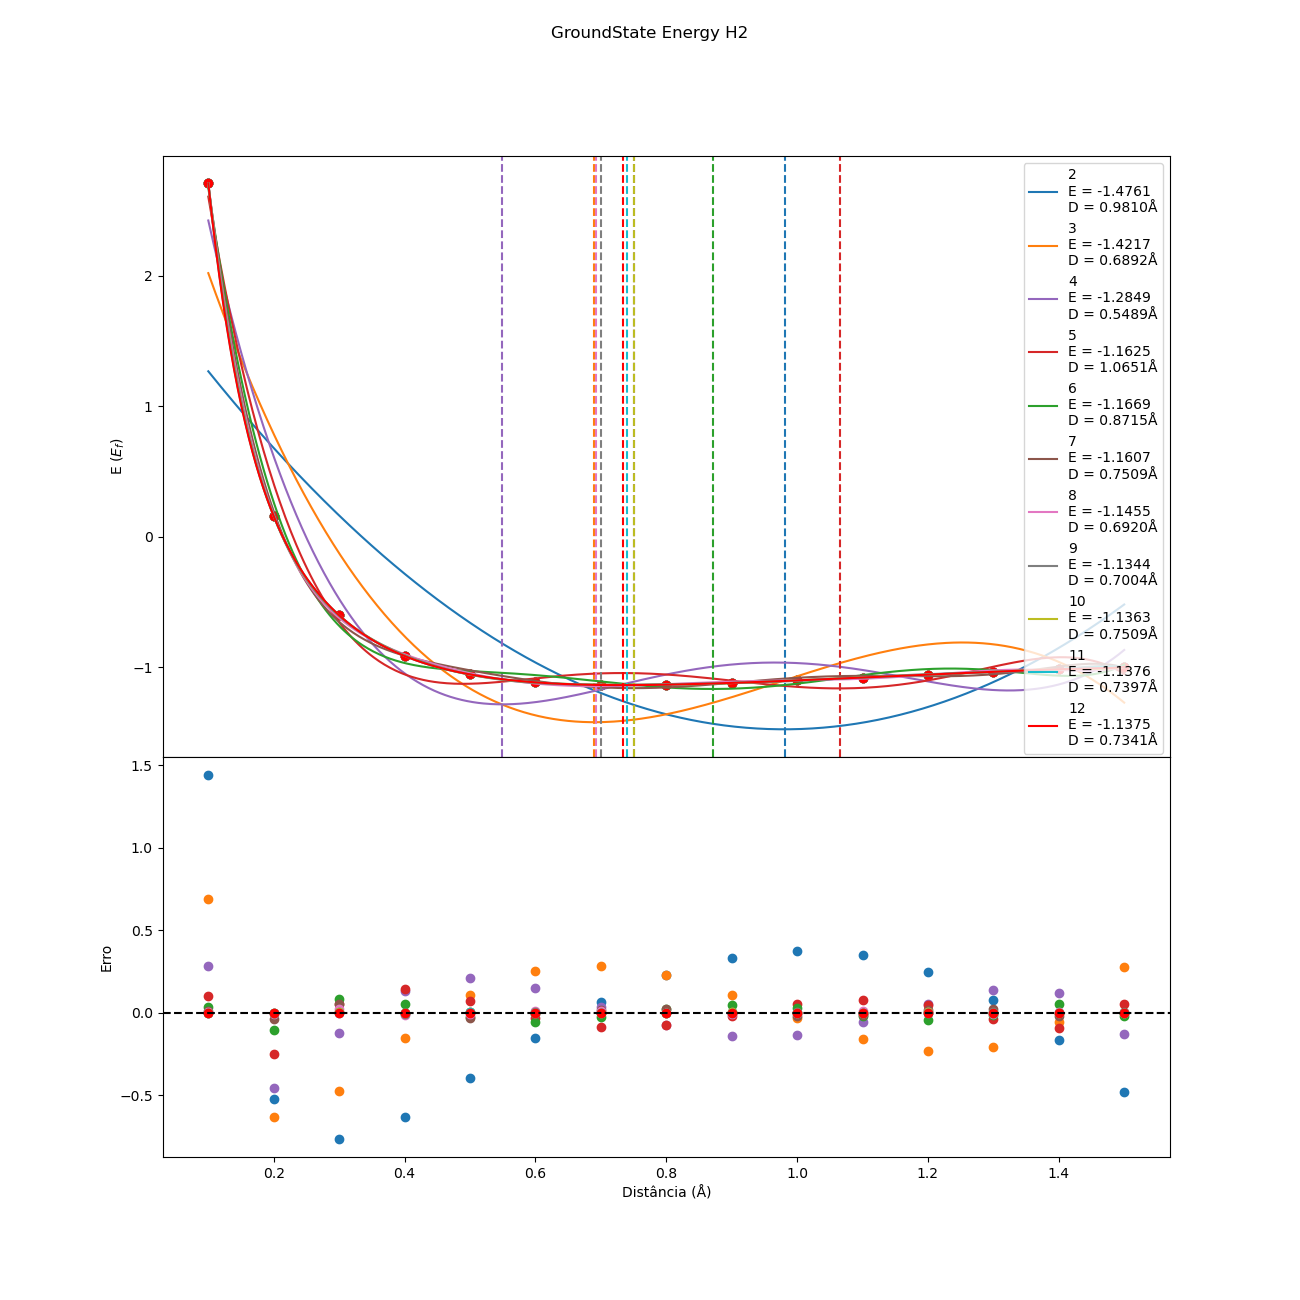

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(13, 13), gridspec_kw={'height_ratios': [3, 2], 'hspace': 0})


for a,b in zip(metodos, ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'red', 'black']):
    
    ax1.plot((x_importante := np.linspace(min(intervalo_importante), max(intervalo_importante), 500)), (y_importante := np.polyval(eval(f"coef_polyfit_inportante_{a}"), x_importante)), label=f'{a}\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å', color = b)
    ax1.scatter(intervalo_importante, eval(f"energy_polyfit_importante_{a}"), color = b)
    #ax1.scatter(intervalo, eval(f"energy_polyfit_{a}"), color = b)

    ax1.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)
    
    ax2.plot(intervalo_importante, eval(f"energy_polyfit_importante_{a}") - np.polyval(eval(f"coef_polyfit_inportante_{a}"), intervalo_importante), 'o', color = b, label='Erro - Importante')

ax2.axhline(y=0, color='k', linestyle='--')

ax1.legend()
#ax2.legend()

ax2.set_xlabel('Distância (Å)')
ax1.set_ylabel('E $(E_f)$')
ax2.set_ylabel('Erro')

fig.suptitle('GroundState Energy H2')



Text(0.5, 0.98, 'GroundState Energy H2')

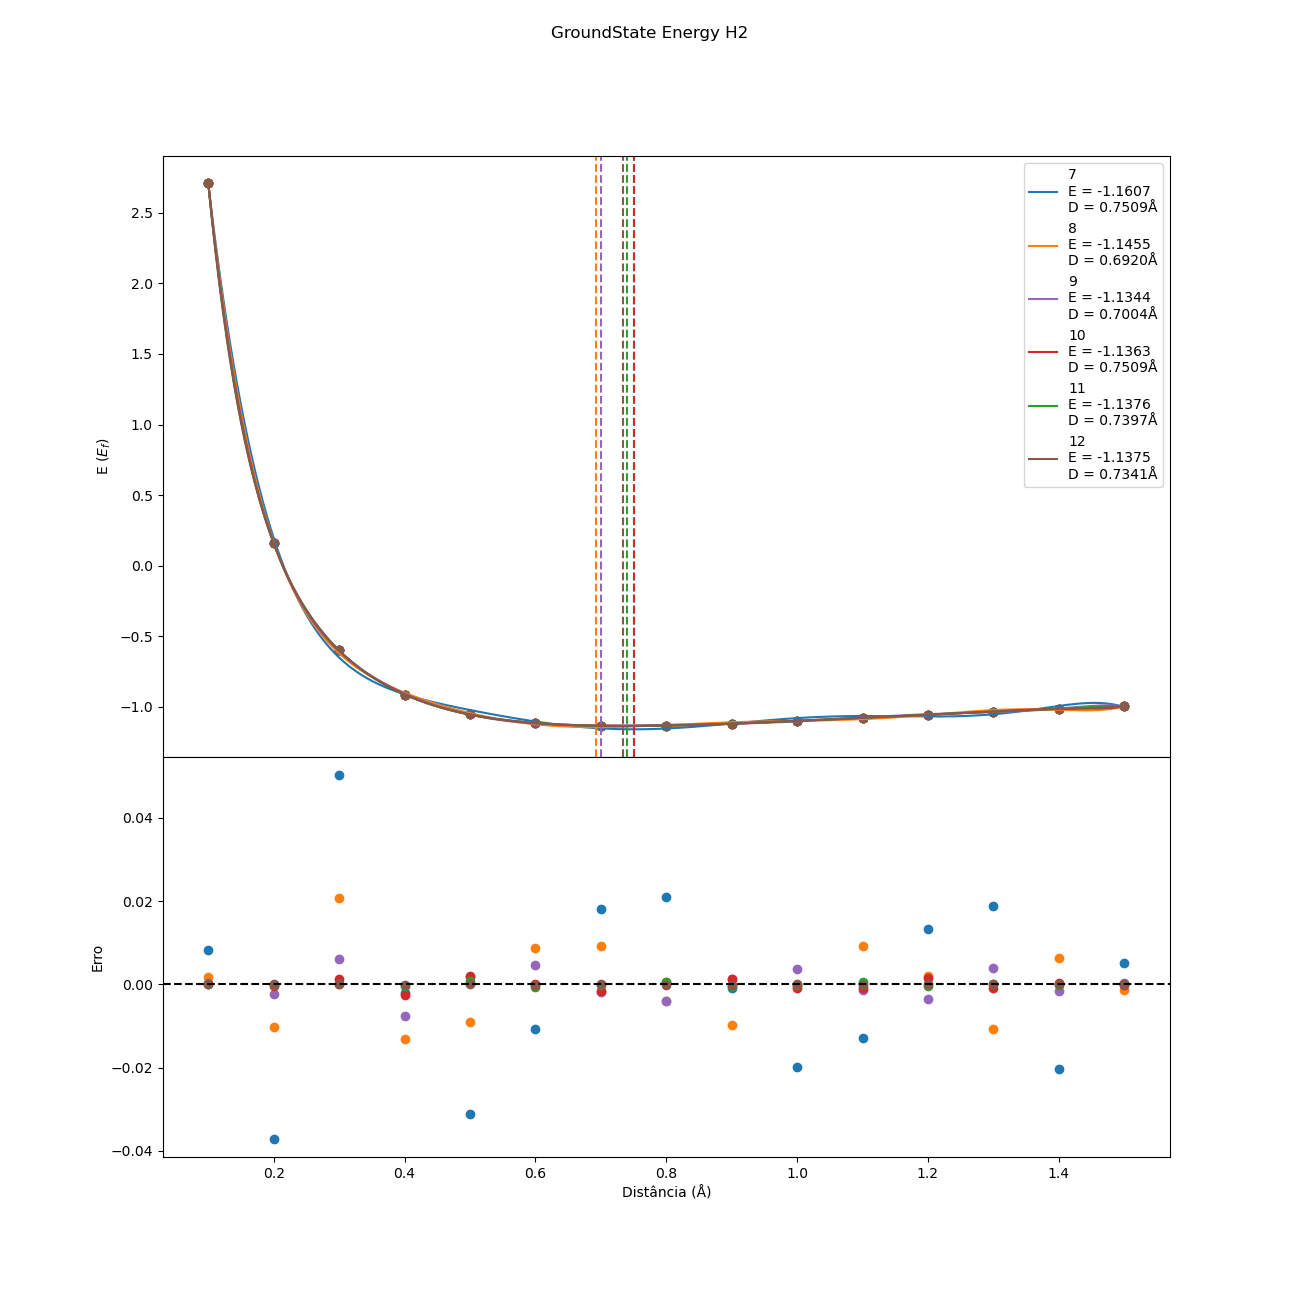

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(13, 13), gridspec_kw={'height_ratios': [3, 2], 'hspace': 0})

diff = []

for a,b in zip(metodos[5:], ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'red', 'black']):
    
    ax1.plot((x_importante := np.linspace(min(intervalo_importante), max(intervalo_importante), 500)), (y_importante := np.polyval(eval(f"coef_polyfit_inportante_{a}"), x_importante)), label=f'{a}\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å', color = b)
    ax1.scatter(intervalo_importante, eval(f"energy_polyfit_importante_{a}"), color = b)
    #ax1.scatter(intervalo, eval(f"energy_polyfit_{a}"), color = b)

    ax1.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)
    
    ax2.plot(intervalo_importante, dif := eval(f"energy_polyfit_importante_{a}") - np.polyval(eval(f"coef_polyfit_inportante_{a}"), intervalo_importante), 'o', color = b, label='Erro - Importante')

    diff.append([a, np.var(dif)])

ax2.axhline(y=0, color='k', linestyle='--')

ax1.legend()
#ax2.legend()

ax2.set_xlabel('Distância (Å)')
ax1.set_ylabel('E $(E_f)$')
ax2.set_ylabel('Erro')

fig.suptitle('GroundState Energy H2')

In [6]:
diff

[[7, 0.0004913169121615433],
 [8, 8.768777992659323e-05],
 [9, 1.2798937521142862e-05],
 [10, 1.4951644687623353e-06],
 [11, 1.3173222042299953e-07],
 [12, 7.628381348223036e-09]]

In [7]:
def morse(x, d, a, r, v):

    return (d * (np.exp(-2*a*(x-r))-2*np.exp(-a*(x-r))) + v) 

popt, pcov = curve_fit(morse, intervalo_importante, energy_polyfit_importante_12, maxfev=40000000)
popt2, pcov2 = curve_fit(morse, intervalo, energy_polyfit_12)

Text(0.5, 0.98, 'GroundState Energy H2')

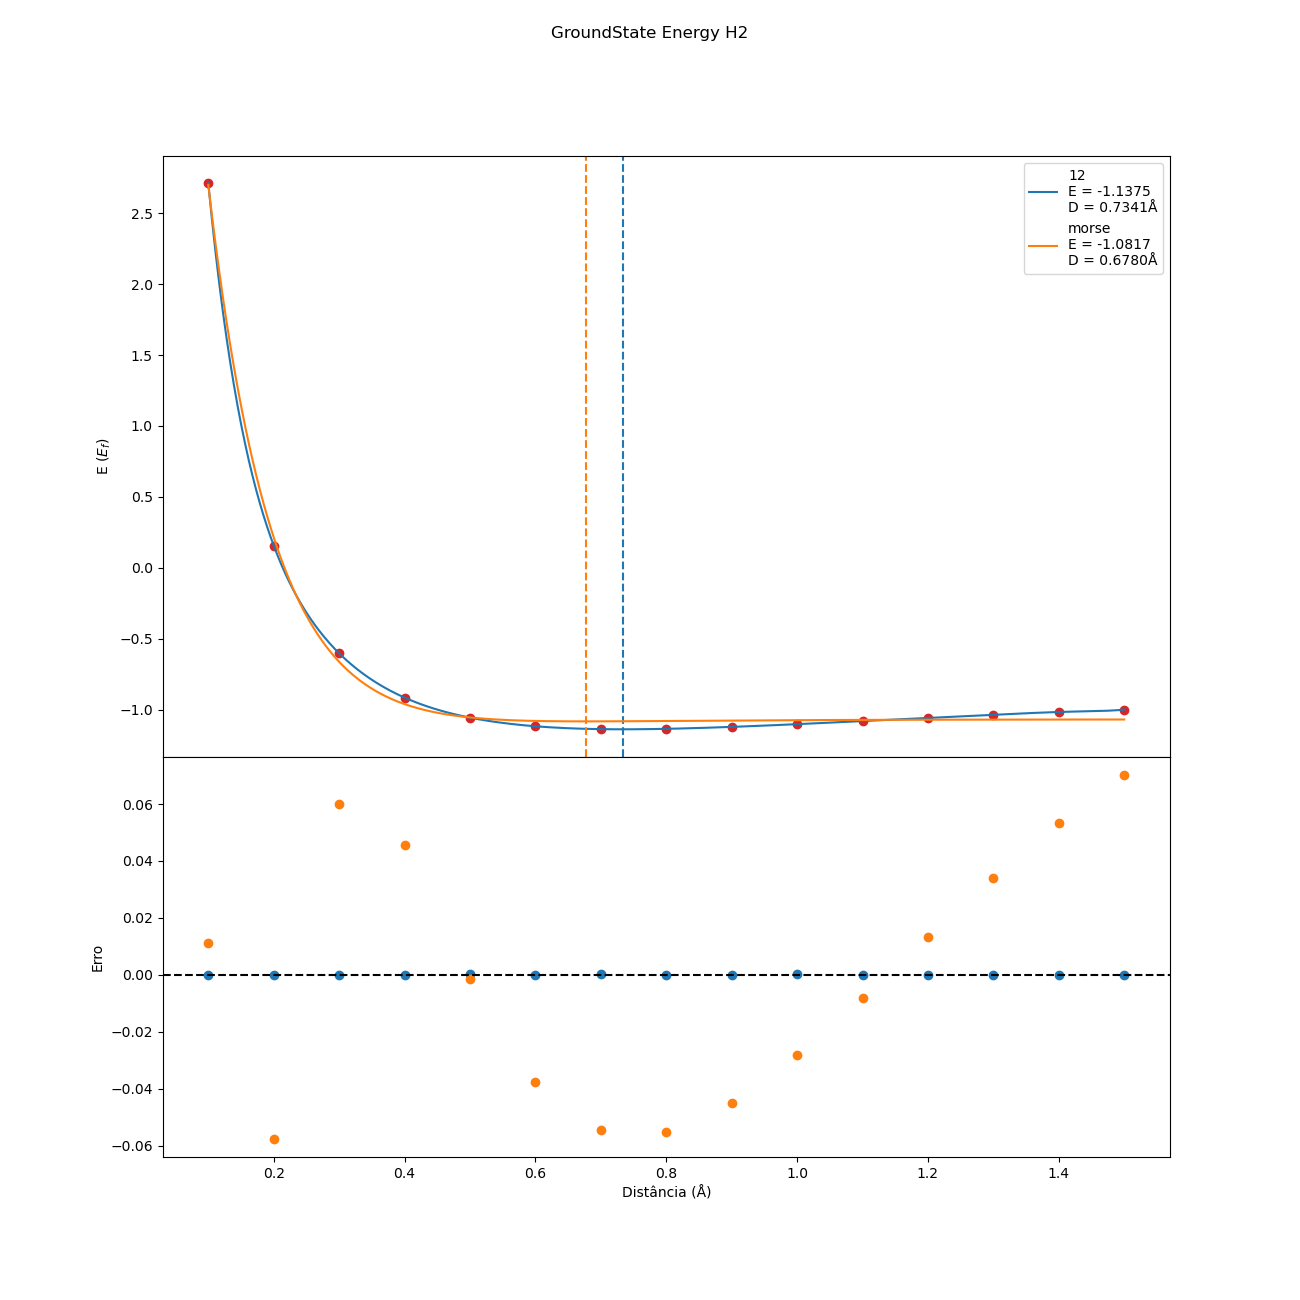

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(13, 13), gridspec_kw={'height_ratios': [3, 2], 'hspace': 0})

ax1.plot((x_importante := np.linspace(min(intervalo_importante), max(intervalo_importante), 500)), (y_importante := np.polyval(coef_polyfit_inportante_12, x_importante)), label=f'12\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å', color = 'tab:blue')
ax1.axvline(x = x_importante[np.argmin(y_importante)], linestyle='--', color='tab:blue')

ax1.plot(x_importante, (y_importante := morse(x_importante, *popt)), label=f'morse\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å', color = 'tab:orange')
ax1.axvline(x = x_importante[np.argmin(y_importante)], linestyle='--', color='tab:orange')

ax1.scatter(intervalo_importante, energy_polyfit_importante_12, color = 'tab:red')

ax2.plot(intervalo_importante, eval(f"energy_polyfit_importante_12") - np.polyval(eval(f"coef_polyfit_inportante_12"), intervalo_importante), 'o', color = 'tab:blue', label='Erro - PolyFit 12')
ax2.plot(intervalo_importante, eval(f"energy_polyfit_importante_12") - morse(intervalo_importante, *popt), 'o', color = 'tab:orange', label='Erro - Morse')

ax2.axhline(y=0, color='k', linestyle='--')

ax1.legend()
#ax2.legend()

ax2.set_xlabel('Distância (Å)')
ax1.set_ylabel('E $(E_f)$')
ax2.set_ylabel('Erro')

fig.suptitle('GroundState Energy H2')

Text(0.5, 0.98, 'GroundState Energy H2')

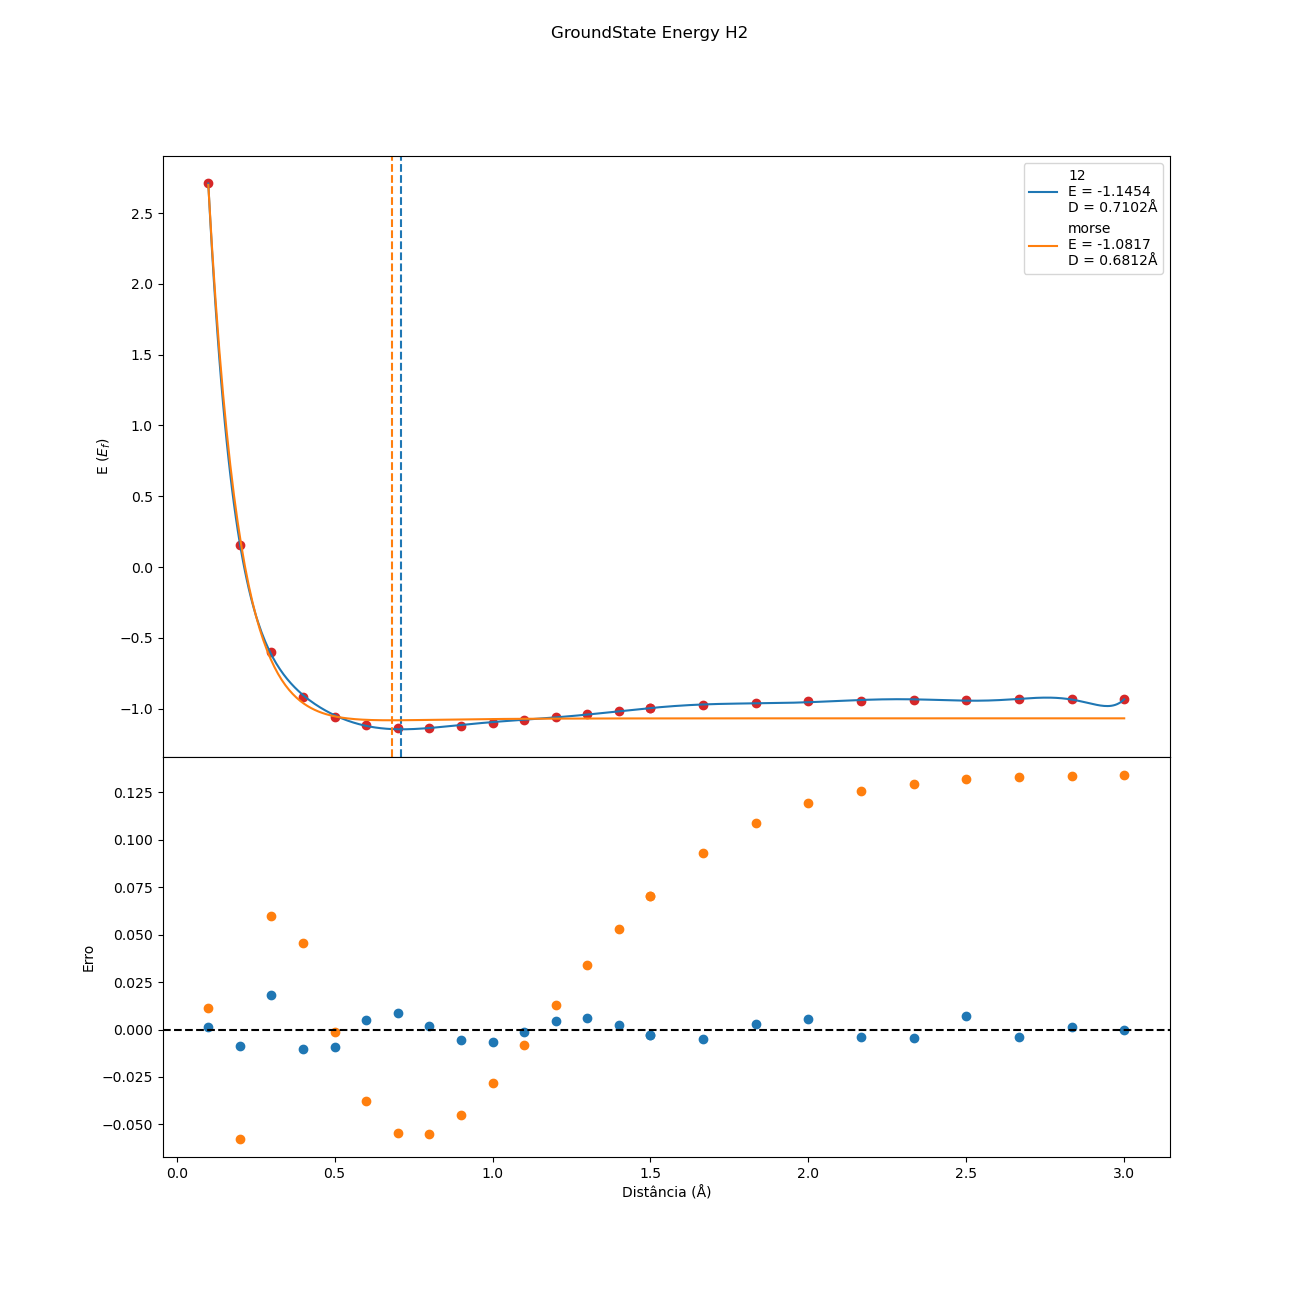

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(13, 13), gridspec_kw={'height_ratios': [3, 2], 'hspace': 0})

ax1.plot((x_importante := np.linspace(min(intervalo), max(intervalo), 500)), (y_importante := np.polyval(coef_polyfit_12, x_importante)), label=f'12\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å', color = 'tab:blue')
ax1.axvline(x = x_importante[np.argmin(y_importante)], linestyle='--', color='tab:blue')

ax1.plot(x_importante, (y_importante := morse(x_importante, *popt)), label=f'morse\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å', color = 'tab:orange')
ax1.axvline(x = x_importante[np.argmin(y_importante)], linestyle='--', color='tab:orange')

ax1.scatter(intervalo, energy_polyfit_12, color = 'tab:red')

ax2.plot(intervalo, eval(f"energy_polyfit_12") - np.polyval(eval(f"coef_polyfit_12"), intervalo), 'o', color = 'tab:blue', label='Erro - PolyFit 12')
ax2.plot(intervalo, eval(f"energy_polyfit_12") - morse(intervalo, *popt), 'o', color = 'tab:orange', label='Erro - Morse')

ax2.axhline(y=0, color='k', linestyle='--')

ax1.legend()
#ax2.legend()

ax2.set_xlabel('Distância (Å)')
ax1.set_ylabel('E $(E_f)$')
ax2.set_ylabel('Erro')

fig.suptitle('GroundState Energy H2')

# Comparando NumPyMinimumEigensolver, VQE (Estimator_Nature, Estimator_Aer) NoiseLess

In [10]:
intervalo_total = np.concatenate(((intervalo := np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))), (intervalo_distante := np.linspace(20, 30, 10))))

print(np.array(GroundState_H2().groundstate_curve(intervalo)))


<generator object GroundState_H2.groundstate_curve at 0x7f2e3807ac00>


In [11]:
intervalo_total = np.concatenate(((intervalo := np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))), (intervalo_distante := np.linspace(20, 30, 10))))

energia_NPMin_intervalo = np.fromiter(GroundState_H2().groundstate_curve(intervalo), float) - np.polyfit(intervalo_distante, list(GroundState_H2().groundstate_curve(intervalo_distante)), 0)
coef_NPMin_intervalo = np.polyfit(intervalo, energia_NPMin_intervalo, 12)

coef_NPMin_intervalo_importante = np.polyfit(intervalo_importante, (energia_NPMin_intervalo_importante := energia_NPMin_intervalo[:len(intervalo_importante)]), 12)


energia_Estimator_Nature_intervalo = np.fromiter((groundstate := GroundState_H2()).groundstate_curve(intervalo, solver = lambda : Solver(groundstate, estimator = Estimator_Nature).Ansatz().Estimator().Vqe()), float) - np.polyfit(intervalo_distante, list((groundstate := GroundState_H2()).groundstate_curve(intervalo_distante, solver = lambda : Solver(groundstate, estimator = Estimator_Nature).Ansatz().Estimator().Vqe())), 0)
coef_Estimator_Nature_intervalo = np.polyfit(intervalo, energia_Estimator_Nature_intervalo, 12)

coef_Estimator_Nature_intervalo_importante = np.polyfit(intervalo_importante, (energia_Estimator_Nature_intervalo_importante := energia_Estimator_Nature_intervalo[:len(intervalo_importante)]), 12)


energia_Estimator_Aer_intervalo = np.fromiter((groundstate := GroundState_H2()).groundstate_curve(intervalo, solver = lambda : Solver(groundstate, estimator = Estimator_Aer).Ansatz().Estimator().Vqe()), float) - np.polyfit(intervalo_distante, list((groundstate := GroundState_H2()).groundstate_curve(intervalo_distante, solver = lambda : Solver(groundstate, estimator = Estimator_Aer).Ansatz().Estimator().Vqe())), 0)
coef_Estimator_Aer_intervalo = np.polyfit(intervalo, energia_Estimator_Aer_intervalo, 12)

coef_Estimator_Aer_intervalo_importante = np.polyfit(intervalo_importante, (energia_Estimator_Aer_intervalo_importante := energia_Estimator_Aer_intervalo[:len(intervalo_importante)]), 12)

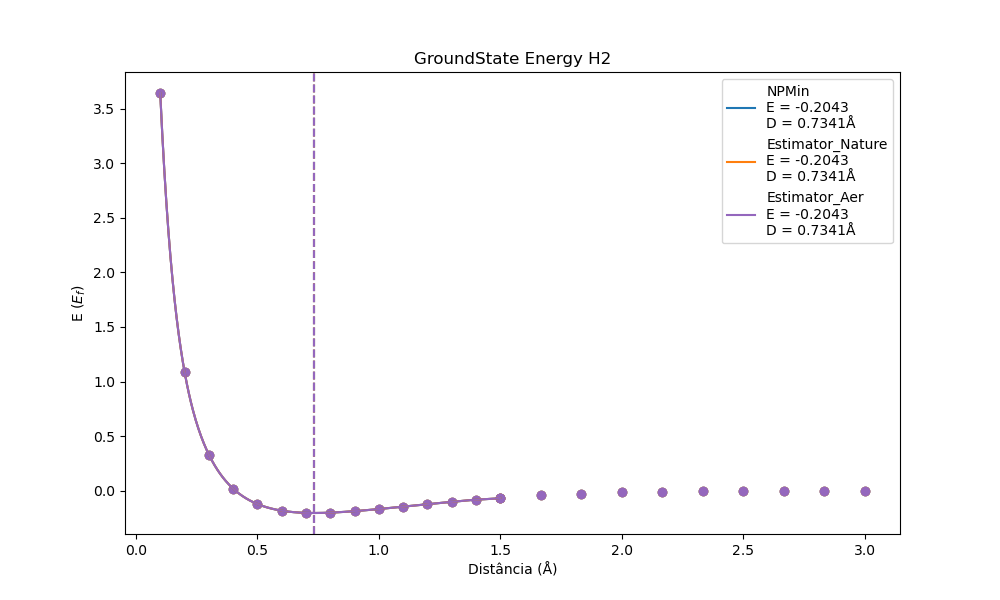

In [12]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()


for a,b in zip(metodos := ['NPMin', 'Estimator_Nature', 'Estimator_Aer'], ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'lime']):
    
    ax.plot((x_importante := np.linspace(min(intervalo_importante), max(intervalo_importante), 500)), (y_importante := np.polyval(eval(f"coef_{a}_intervalo_importante"), x_importante)), label=f'{a}\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å', color = b)
    ax.scatter(intervalo, eval(f"energia_{a}_intervalo"), color = b)
    
    ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)
    

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(E_f)$')

ax.set_title('GroundState Energy H2')

ax.legend()

## Comparando Número de Shots (Estimator_Aer)

In [3]:
intervalo_total = np.concatenate(((intervalo := np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))), (intervalo_distante := np.linspace(20, 30, 10))))

for a in (metodos := range(1, 100, 10)):
    
    exec(f"energia_Estimator_Aer_intervalo_{a} = np.fromiter((groundstate := GroundState_H2()).groundstate_curve(intervalo, solver = lambda : Solver(groundstate, estimator = Estimator_Aer).Ansatz().Estimator(shots = {a}).Vqe()), float) - np.polyfit(intervalo_distante, list((groundstate := GroundState_H2()).groundstate_curve(intervalo_distante, solver = lambda : Solver(groundstate, estimator = Estimator_Aer).Ansatz().Estimator(shots = {a}).Vqe())), 0)")
    exec(f"coef_Estimator_Aer_intervalo_{a} = np.polyfit(intervalo, energia_Estimator_Aer_intervalo_{a}, 12)")

    exec(f"coef_Estimator_Aer_intervalo_importante_{a} = np.polyfit(intervalo_importante, (energia_Estimator_Aer_intervalo_importante_{a} := energia_Estimator_Aer_intervalo_{a}[:len(intervalo_importante)]), 12)")

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
81
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91
91


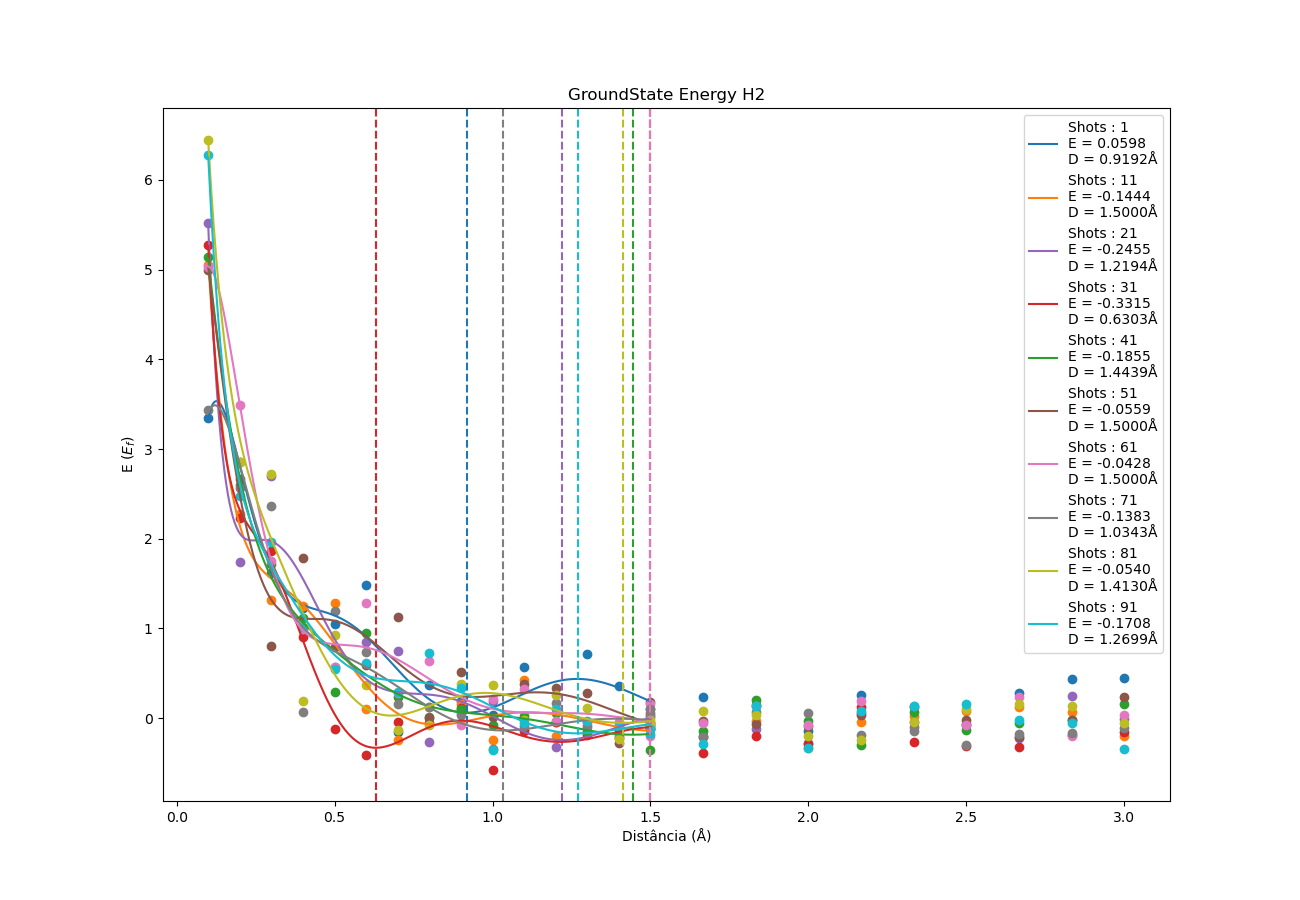

In [14]:
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot()


for a,b in zip(metodos, ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'lime']):
    
    ax.plot((x_importante := np.linspace(min(intervalo_importante), max(intervalo_importante), 500)), (y_importante := np.polyval(eval(f"coef_Estimator_Aer_intervalo_{a}"), x_importante)), label=f'Shots : {a}\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å', color = b)
    ax.scatter(intervalo, eval(f"energia_Estimator_Aer_intervalo_{a}"), color = b)
    
    ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)
    

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(E_f)$')

ax.set_title('GroundState Energy H2')

ax.legend()

In [15]:
intervalo_total = np.concatenate(((intervalo := np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))), (intervalo_distante := np.linspace(20, 30, 10))))

for a in (metodos := range(100, 1000, 100)):
    
    exec(f"energia_Estimator_Aer_intervalo_{a} = np.fromiter((groundstate := GroundState_H2()).groundstate_curve(intervalo, solver = lambda : Solver(groundstate, estimator = Estimator_Aer).Ansatz().Estimator(shots = {a}).Vqe()), float) - np.polyfit(intervalo_distante, list((groundstate := GroundState_H2()).groundstate_curve(intervalo_distante, solver = lambda : Solver(groundstate, estimator = Estimator_Aer).Ansatz().Estimator(shots = {a}).Vqe())), 0)")
    exec(f"coef_Estimator_Aer_intervalo_{a} = np.polyfit(intervalo, energia_Estimator_Aer_intervalo_{a}, 12)")

    exec(f"coef_Estimator_Aer_intervalo_importante_{a} = np.polyfit(intervalo_importante, (energia_Estimator_Aer_intervalo_importante_{a} := energia_Estimator_Aer_intervalo_{a}[:len(intervalo_importante)]), 12)")

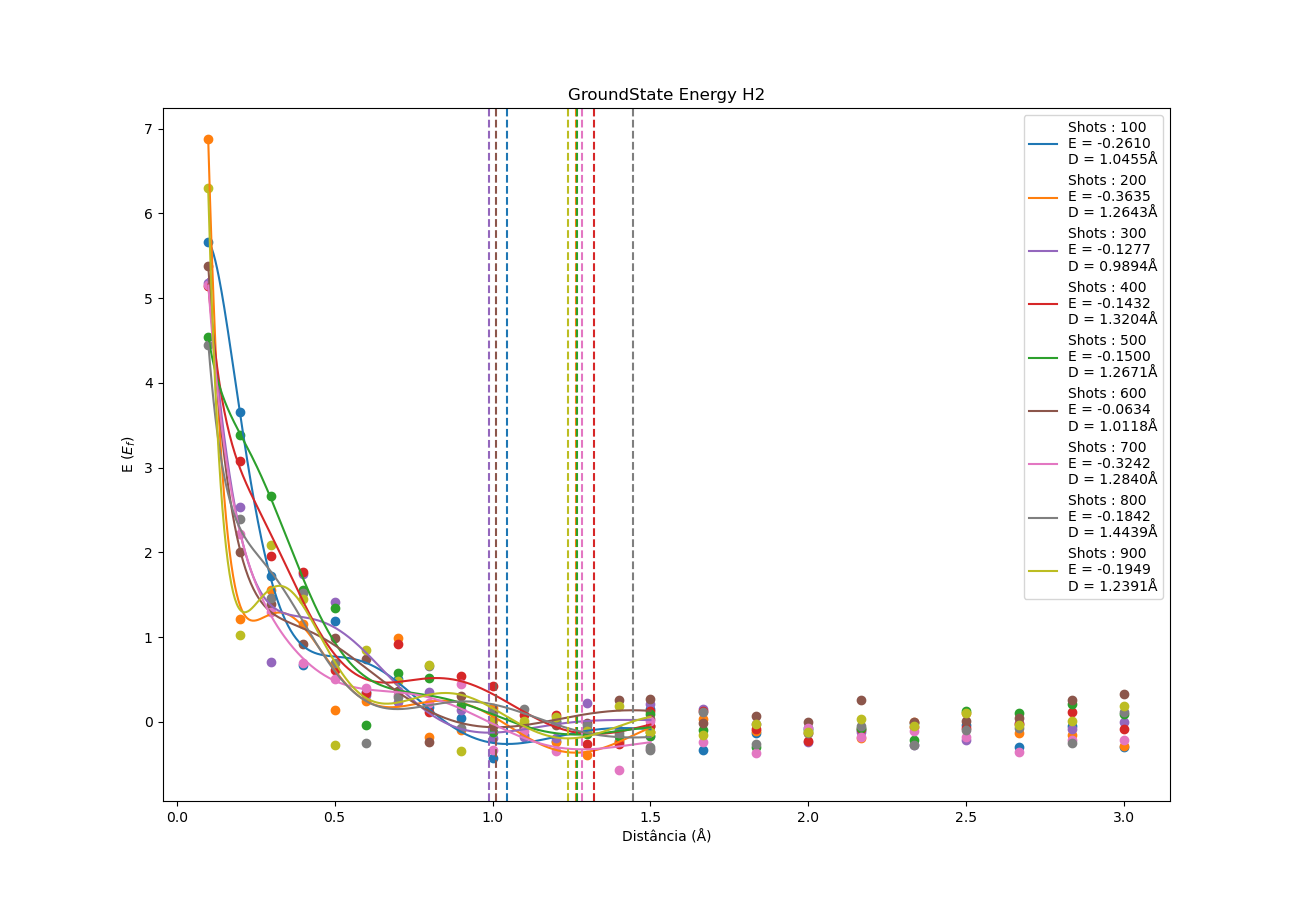

In [16]:
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot()


for a,b in zip(metodos, ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'lime']):
    
    ax.plot((x_importante := np.linspace(min(intervalo_importante), max(intervalo_importante), 500)), (y_importante := np.polyval(eval(f"coef_Estimator_Aer_intervalo_{a}"), x_importante)), label=f'Shots : {a}\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å', color = b)
    ax.scatter(intervalo, eval(f"energia_Estimator_Aer_intervalo_{a}"), color = b)
    
    ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)
    

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(E_f)$')

ax.set_title('GroundState Energy H2')

ax.legend()

In [17]:
intervalo_total = np.concatenate(((intervalo := np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))), (intervalo_distante := np.linspace(20, 30, 10))))

for a in (metodos := range(1000, 11000, 1000)):
    
    exec(f"energia_Estimator_Aer_intervalo_{a} = np.fromiter((groundstate := GroundState_H2()).groundstate_curve(intervalo, solver = lambda : Solver(groundstate, estimator = Estimator_Aer).Ansatz().Estimator(shots = {a}).Vqe()), float) - np.polyfit(intervalo_distante, list((groundstate := GroundState_H2()).groundstate_curve(intervalo_distante, solver = lambda : Solver(groundstate, estimator = Estimator_Aer).Ansatz().Estimator(shots = {a}).Vqe())), 0)")
    exec(f"coef_Estimator_Aer_intervalo_{a} = np.polyfit(intervalo, energia_Estimator_Aer_intervalo_{a}, 12)")

    exec(f"coef_Estimator_Aer_intervalo_importante_{a} = np.polyfit(intervalo_importante, (energia_Estimator_Aer_intervalo_importante_{a} := energia_Estimator_Aer_intervalo_{a}[:len(intervalo_importante)]), 12)")

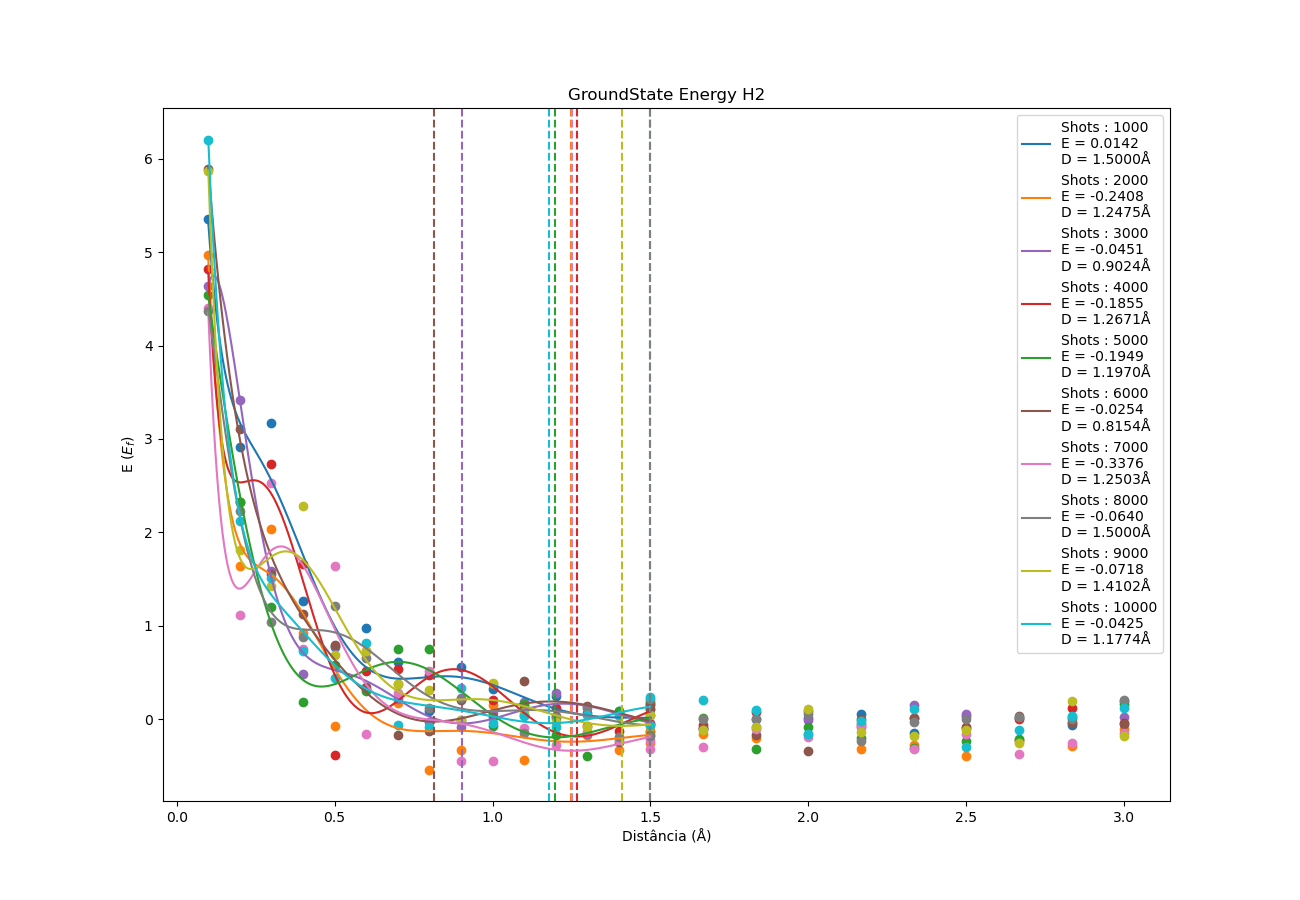

In [18]:
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot()


for a,b in zip(metodos, ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'lime']):
    
    ax.plot((x_importante := np.linspace(min(intervalo_importante), max(intervalo_importante), 500)), (y_importante := np.polyval(eval(f"coef_Estimator_Aer_intervalo_{a}"), x_importante)), label=f'Shots : {a}\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å', color = b)
    ax.scatter(intervalo, eval(f"energia_Estimator_Aer_intervalo_{a}"), color = b)
    
    ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)
    

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(E_f)$')

ax.set_title('GroundState Energy H2')

ax.legend()

In [19]:
intervalo_total = np.concatenate(((intervalo := np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))), (intervalo_distante := np.linspace(20, 30, 10))))

for a in (metodos := range(10000, 110000, 10000)):
    
    exec(f"energia_Estimator_Aer_intervalo_{a} = np.fromiter((groundstate := GroundState_H2()).groundstate_curve(intervalo, solver = lambda : Solver(groundstate, estimator = Estimator_Aer).Ansatz().Estimator(shots = {a}).Vqe()), float) - np.polyfit(intervalo_distante, list((groundstate := GroundState_H2()).groundstate_curve(intervalo_distante, solver = lambda : Solver(groundstate, estimator = Estimator_Aer).Ansatz().Estimator(shots = {a}).Vqe())), 0)")
    exec(f"coef_Estimator_Aer_intervalo_{a} = np.polyfit(intervalo, energia_Estimator_Aer_intervalo_{a}, 12)")

    exec(f"coef_Estimator_Aer_intervalo_importante_{a} = np.polyfit(intervalo_importante, (energia_Estimator_Aer_intervalo_importante_{a} := energia_Estimator_Aer_intervalo_{a}[:len(intervalo_importante)]), 12)")

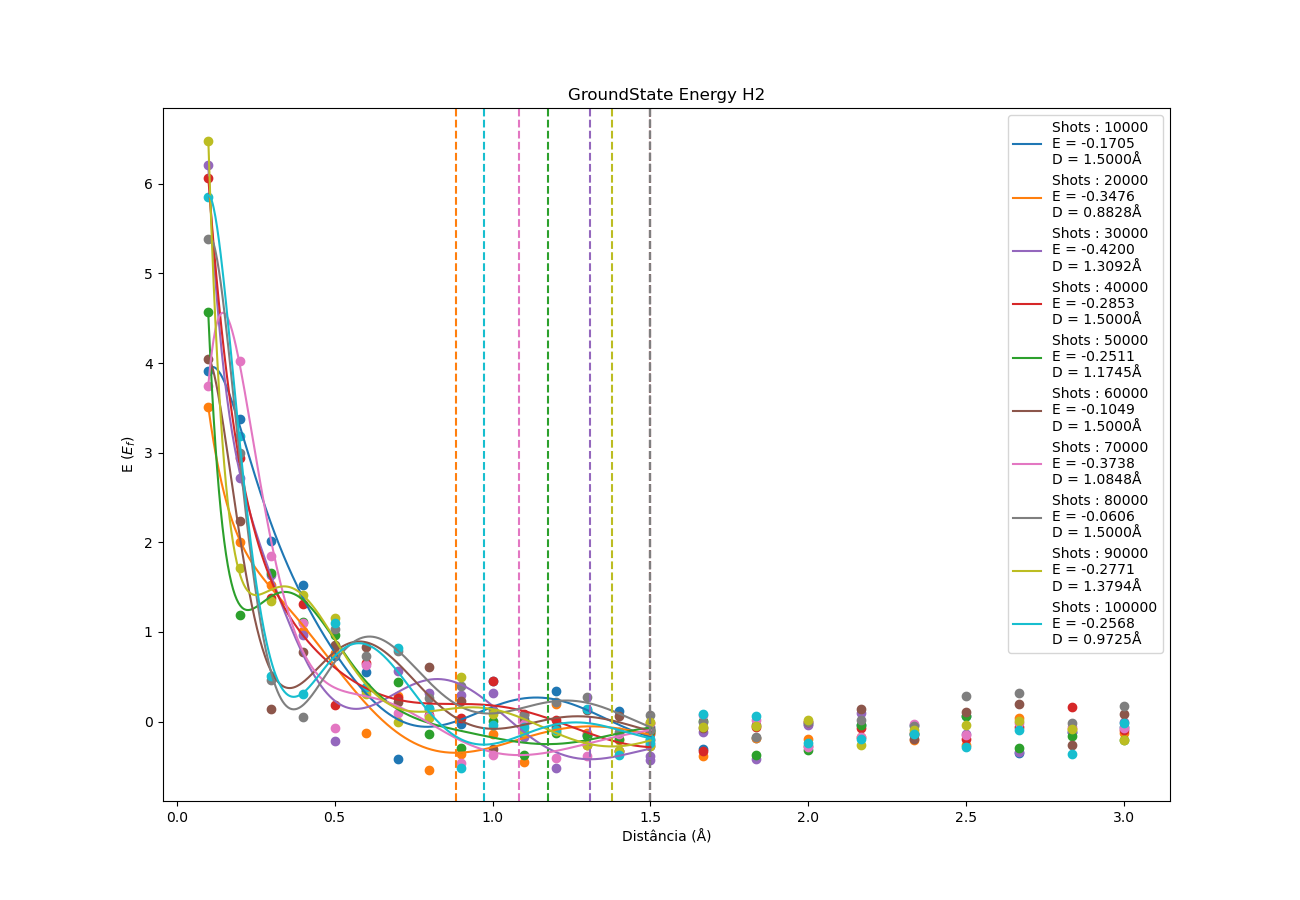

In [20]:
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot()


for a,b in zip(metodos, ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'lime']):
    
    ax.plot((x_importante := np.linspace(min(intervalo_importante), max(intervalo_importante), 500)), (y_importante := np.polyval(eval(f"coef_Estimator_Aer_intervalo_{a}"), x_importante)), label=f'Shots : {a}\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å', color = b)
    ax.scatter(intervalo, eval(f"energia_Estimator_Aer_intervalo_{a}"), color = b)
    
    ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)
    

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(E_f)$')

ax.set_title('GroundState Energy H2')

ax.legend()

## Comparando Número de Shots (Estimator_Nature)

In [21]:
intervalo_total = np.concatenate(((intervalo := np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))), (intervalo_distante := np.linspace(20, 30, 10))))

#for a in (metodos := range(100, 1000, 100)):
for a in (metodos := [1, 5, 10, 50, 100, 1000]):
    
    exec(f"energia_Estimator_Nature_intervalo_{a} = np.fromiter((groundstate := GroundState_H2()).groundstate_curve(intervalo, solver = lambda : Solver(groundstate, estimator = Estimator_Nature).Ansatz().Estimator(shots = {a}).Vqe()), float) - np.polyfit(intervalo_distante, list((groundstate := GroundState_H2()).groundstate_curve(intervalo_distante, solver = lambda : Solver(groundstate, estimator = Estimator_Nature).Ansatz().Estimator(shots = {a}).Vqe())), 0)")
    exec(f"coef_Estimator_Nature_intervalo_{a} = np.polyfit(intervalo, energia_Estimator_Nature_intervalo_{a}, 12)")

    exec(f"coef_Estimator_Nature_intervalo_importante_{a} = np.polyfit(intervalo_importante, (energia_Estimator_Nature_intervalo_importante_{a} := energia_Estimator_Nature_intervalo_{a}[:len(intervalo_importante)]), 12)")

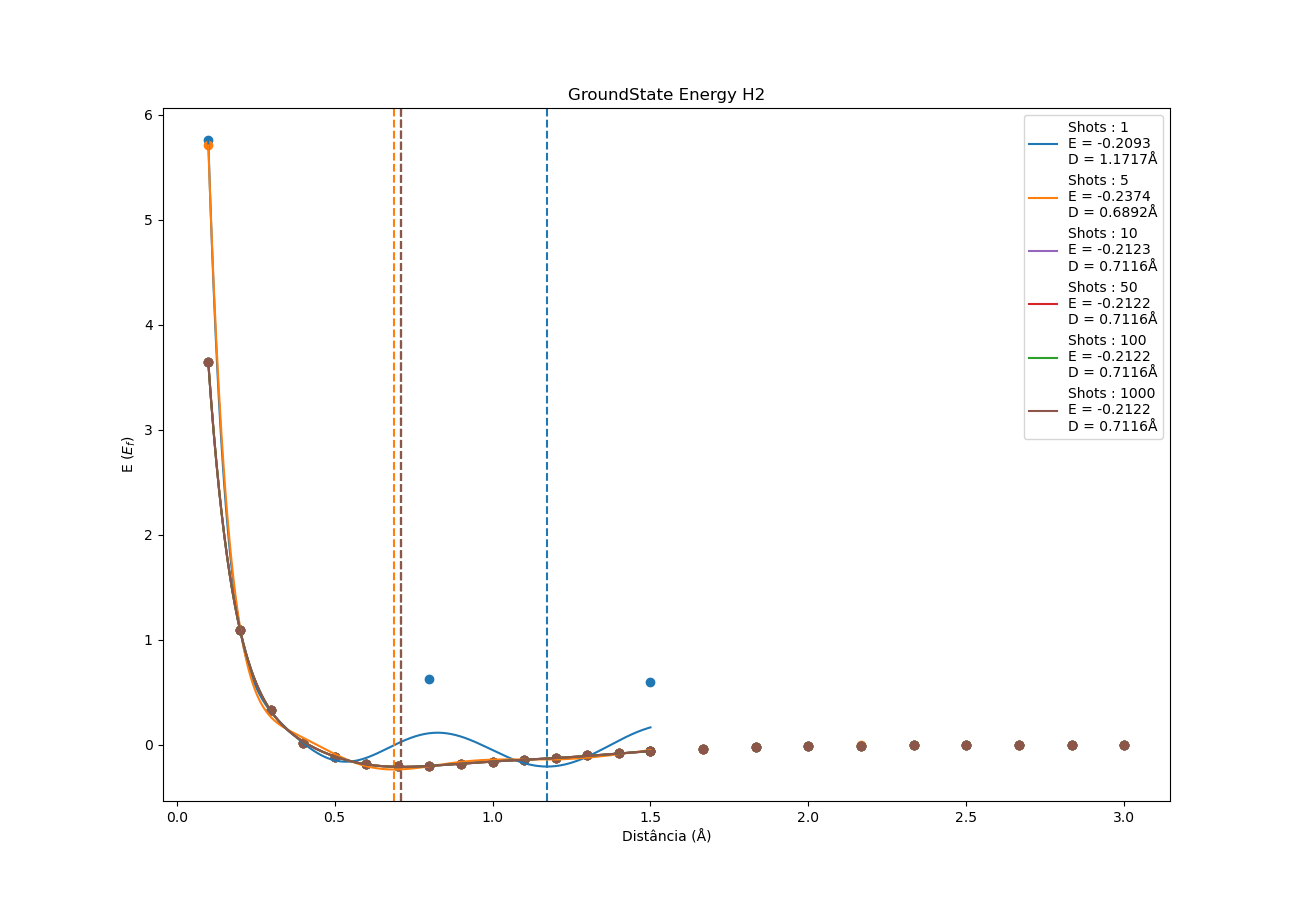

In [22]:
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot()


for a,b in zip(metodos, ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'lime']):
    
    ax.plot((x_importante := np.linspace(min(intervalo_importante), max(intervalo_importante), 500)), (y_importante := np.polyval(eval(f"coef_Estimator_Nature_intervalo_{a}"), x_importante)), label=f'Shots : {a}\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å', color = b)
    ax.scatter(intervalo, eval(f"energia_Estimator_Nature_intervalo_{a}"), color = b)
    
    ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)
    

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(E_f)$')

ax.set_title('GroundState Energy H2')

ax.legend()

# Comparando Noises (Estimator_Aer)

In [28]:
intervalo_total = np.concatenate(((intervalo := np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))), (intervalo_distante := np.linspace(20, 30, 10))))

for a in (metodos := ['FakePerth', 'FakeLagosV2', 'FakeNairobiV2']):
    
    exec(f"energia_Estimator_Aer_intervalo_{a} = np.fromiter((groundstate := GroundState_H2()).groundstate_curve(intervalo, solver = lambda : Solver(groundstate, estimator = Estimator_Aer).Ansatz().Estimator(shots = None, noise = {a}).Vqe()), float) - np.polyfit(intervalo_distante, list((groundstate := GroundState_H2()).groundstate_curve(intervalo_distante, solver = lambda : Solver(groundstate, estimator = Estimator_Aer).Ansatz().Estimator(shots = 5000, noise = {a}).Vqe())), 0)")
    exec(f"coef_Estimator_Aer_intervalo_{a} = np.polyfit(intervalo, energia_Estimator_Aer_intervalo_{a}, 12)")

    exec(f"coef_Estimator_Aer_intervalo_importante_{a} = np.polyfit(intervalo_importante, (energia_Estimator_Aer_intervalo_importante_{a} := energia_Estimator_Aer_intervalo_{a}[:len(intervalo_importante)]), 12)")

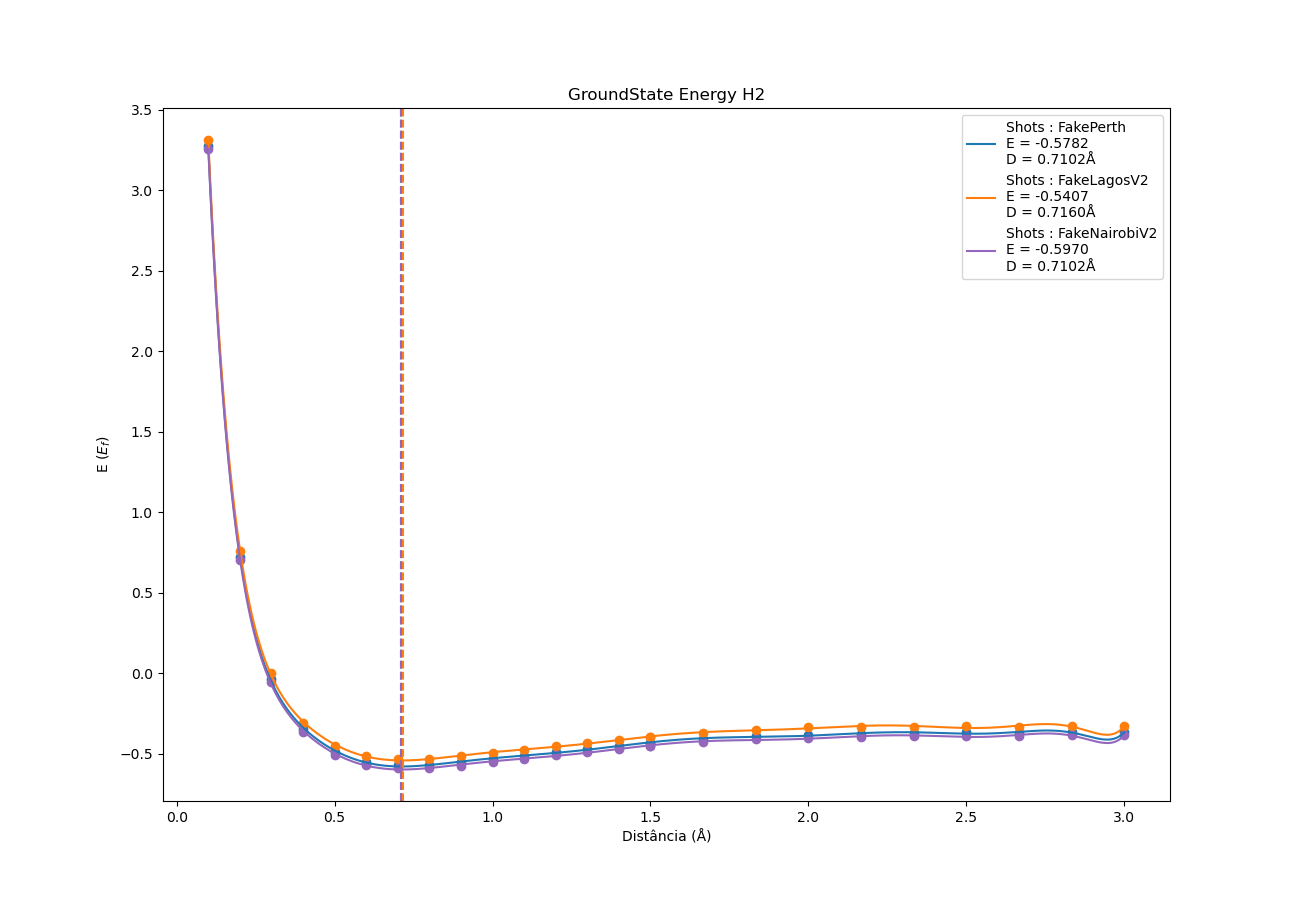

In [29]:
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot()


for a,b in zip(metodos, ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'lime']):
    
    ax.plot((x_importante := np.linspace(min(intervalo), max(intervalo), 500)), (y_importante := np.polyval(eval(f"coef_Estimator_Aer_intervalo_{a}"), x_importante)), label=f'Shots : {a}\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å', color = b)
    ax.scatter(intervalo, eval(f"energia_Estimator_Aer_intervalo_{a}"), color = b)
    
    ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)
    

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(E_f)$')

ax.set_title('GroundState Energy H2')

ax.legend()

In [30]:
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(channel="ibm_quantum", token="309519564c3cdfe761814eb31dda8f2f3db3ca6e7e248e6a4504a0e415ea3317e24a74225b1b4dba4bda33fac3f148db6c3317bd09648fdcce8c17e0699bd4f1", set_as_default=True, overwrite=True)
service = QiskitRuntimeService()
backend = service.backend("ibmq_qasm_simulator")
session = Session(backend=backend)